In [727]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram
from sklearn.base import clone
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
import graphviz


In [838]:
## Load Dataset
data = pd.read_sas('a2z_insurance.sas7bdat')
data

,CustID,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
0,1.0,1985.0,1982.0,b'2 - High School',2177.0,1.0,1.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89
1,2.0,1981.0,1995.0,b'2 - High School',677.0,4.0,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
2,3.0,1991.0,1970.0,b'1 - Basic',2277.0,3.0,0.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02
3,4.0,1990.0,1981.0,b'3 - BSc/MSc',1099.0,4.0,1.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34
4,5.0,1986.0,1973.0,b'3 - BSc/MSc',1763.0,4.0,1.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10291,10292.0,1984.0,1949.0,b'4 - PhD',3188.0,2.0,0.0,-0.11,0.96,393.74,49.45,173.81,9.78,14.78
10292,10293.0,1977.0,1952.0,b'1 - Basic',2431.0,3.0,0.0,1405.60,0.00,133.58,1035.75,143.25,12.89,105.13
10293,10294.0,1994.0,1976.0,b'3 - BSc/MSc',2918.0,1.0,1.0,524.10,0.21,403.63,132.80,142.25,12.67,4.89
10294,10295.0,1981.0,1977.0,b'1 - Basic',1971.0,2.0,1.0,250.05,0.65,188.59,211.15,198.37,63.90,112.91


In [729]:
### Copied from Joice
def educDegtransform(row):
    row = row.decode("utf-8") if type(row) == bytes else row 
    if type(row) == str:
        educ_dict = {
            '1 - Basic': 1,
            '2 - High School': 2,
            '3 - BSc/MSc': 3,
            '4 - PhD': 4
        }
        return educ_dict[row]
    else:
        return row

data['EducDeg'] = data['EducDeg'].apply(lambda row: educDegtransform(row)) 



df = data
df['CustID'] = df['CustID'].astype('int')
df = df.set_index('CustID')


In [731]:
##Number of null values on each column:
df.isnull().sum()

FirstPolYear      30
BirthYear         17
EducDeg           17
MonthSal          36
GeoLivArea         1
Children          21
CustMonVal         0
ClaimsRate         0
PremMotor         34
PremHousehold      0
PremHealth        43
PremLife         104
PremWork          86
dtype: int64

## Inputing missing numerical values

In [732]:
# Define metric and non-metric features
non_metric_features = ['EducDeg', 'GeoLivArea', 'Children']
metric_features = df.columns.drop(non_metric_features).to_list()
metric_features = [x for x in metric_features if x not in 'CustID']

print('non metric features: ', non_metric_features)
print('metric features: ', metric_features)

non metric features:  ['EducDeg', 'GeoLivArea', 'Children']
metric features:  ['FirstPolYear', 'BirthYear', 'MonthSal', 'CustMonVal', 'ClaimsRate', 'PremMotor', 'PremHousehold', 'PremHealth', 'PremLife', 'PremWork']


In [733]:
# Creating new df copy to explore neighbordhood imputation
df_neighbors = df.copy()

# Seeing rows with NaNs
nans_index = df_neighbors.isna().any(axis=1)
df_neighbors[nans_index]

,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
CustID,,,,,,,,,,,,,
22,1977.0,1958.0,2.0,NaN,3.0,1.0,111.37,0.80,407.52,111.70,100.13,24.67,30.34
69,1983.0,1977.0,2.0,1399.0,4.0,1.0,476.65,0.33,330.73,186.70,211.15,NaN,15.78
139,1979.0,1976.0,2.0,2538.0,2.0,1.0,149.59,0.69,194.26,305.60,NaN,37.34,17.67
144,1996.0,1990.0,3.0,NaN,4.0,1.0,-42.45,1.02,146.36,353.95,220.04,121.80,42.01
185,1993.0,1984.0,2.0,2419.0,4.0,1.0,-62.23,1.07,NaN,253.95,230.60,5.89,43.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10011,NaN,1947.0,2.0,3959.0,2.0,NaN,-128.24,1.14,177.81,153.35,311.28,67.79,35.45
10058,1983.0,1980.0,2.0,1569.0,4.0,1.0,222.60,0.55,235.60,211.15,NaN,32.34,68.79
10143,1986.0,1985.0,3.0,1652.0,3.0,1.0,55.67,0.88,257.05,94.45,308.39,NaN,13.78


In [734]:
# KNNImputer - only works for numerical varaibles
imputer = KNNImputer(n_neighbors=5, weights="uniform")
df_neighbors[metric_features] = imputer.fit_transform(df_neighbors[metric_features])

In [735]:
# See rows with NaNs imputed
df_neighbors.loc[nans_index, metric_features]

,FirstPolYear,BirthYear,MonthSal,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
CustID,,,,,,,,,,
22,1977.0,1958.0,2541.2,111.37,0.80,407.520,111.70,100.130,24.670,30.340
69,1983.0,1977.0,1399.0,476.65,0.33,330.730,186.70,211.150,33.784,15.780
139,1979.0,1976.0,2538.0,149.59,0.69,194.260,305.60,226.598,37.340,17.670
144,1996.0,1990.0,1721.8,-42.45,1.02,146.360,353.95,220.040,121.800,42.010
185,1993.0,1984.0,2419.0,-62.23,1.07,264.428,253.95,230.600,5.890,43.120
...,...,...,...,...,...,...,...,...,...,...
10011,1990.8,1947.0,3959.0,-128.24,1.14,177.810,153.35,311.280,67.790,35.450
10058,1983.0,1980.0,1569.0,222.60,0.55,235.600,211.15,247.602,32.340,68.790
10143,1986.0,1985.0,1652.0,55.67,0.88,257.050,94.45,308.390,23.338,13.780


In [736]:
df = df_neighbors.copy()
##Number of null values on each column:
df.isnull().sum()

FirstPolYear      0
BirthYear         0
EducDeg          17
MonthSal          0
GeoLivArea        1
Children         21
CustMonVal        0
ClaimsRate        0
PremMotor         0
PremHousehold     0
PremHealth        0
PremLife          0
PremWork          0
dtype: int64

In [737]:
modes = df[non_metric_features].mode().loc[0]
modes

EducDeg       3.0
GeoLivArea    4.0
Children      1.0
Name: 0, dtype: float64

In [738]:
#df.fillna(df.median(), inplace=True)
df.fillna(modes, inplace=True)
df.isna().sum()  # checking how many NaNs we still have

FirstPolYear     0
BirthYear        0
EducDeg          0
MonthSal         0
GeoLivArea       0
Children         0
CustMonVal       0
ClaimsRate       0
PremMotor        0
PremHousehold    0
PremHealth       0
PremLife         0
PremWork         0
dtype: int64

## Data Normalization

In [739]:
df_scaled = df.copy()

In [740]:
# Use MinMaxScaler to scale the data
#scaler = MinMaxScaler()
scaler = StandardScaler()
scaled_feat = scaler.fit_transform(df_scaled[metric_features])
scaled_feat

array([[-1.18472593e-02,  7.10298788e-01, -2.84984308e-01, ...,
        -8.54107514e-02,  1.13765109e-01, -4.72216171e-01],
       [-1.96827493e-02,  1.37019248e+00, -1.58249621e+00, ...,
        -1.85717553e-01,  3.22839556e+00,  1.26487147e+00],
       [-9.40243577e-05,  1.01166148e-01, -1.98483514e-01, ...,
        -1.59043449e-01,  9.44642995e-01,  1.12647284e+00],
       ...,
       [ 5.78259313e-03,  4.05732468e-01,  3.55986572e-01, ...,
        -9.93056268e-02, -6.11510606e-01, -7.05800345e-01],
       [-1.96827493e-02,  4.56493522e-01, -4.63175943e-01, ...,
         9.04219660e-02,  4.70489244e-01,  1.39684652e+00],
       [-2.05289685e-03,  6.59537735e-01,  2.66890755e-01, ...,
        -1.02686375e-01, -7.33586716e-01, -5.50077562e-01]])

In [741]:
# See what the fit method is doing (notice the trailing underscore):
print("Parameters fitted:\n", scaler.mean_, "\n", scaler.var_)

Parameters fitted:
 [1.99104800e+03 1.96800701e+03 2.50645861e+03 1.77892605e+02
 7.42771950e-01 3.00671206e+02 2.10431192e+02 1.71623860e+02
 4.16235052e+01 4.11493236e+01] 
 [2.60607952e+05 3.88095627e+02 1.33647185e+06 3.78581468e+06
 8.50785046e+00 4.47936531e+04 1.24311853e+05 8.74932061e+04
 2.24178681e+03 2.63922043e+03]


In [742]:
df_scaled[metric_features] = scaled_feat
df_scaled.head()

,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
CustID,,,,,,,,,,,,,
1,-0.011847,0.710299,2.0,-0.284984,1.0,1.0,0.104371,-0.120944,0.355212,-0.371495,-0.085411,0.113765,-0.472216
2,-0.019683,1.370192,2.0,-1.582496,4.0,1.0,-0.158822,0.129328,-1.054649,0.583611,-0.185718,3.228396,1.264871
3,-0.000094,0.101166,1.0,-0.198484,3.0,0.0,0.167947,-0.158656,-0.446602,0.039903,-0.159043,0.944643,1.126473
4,-0.002053,0.659538,3.0,-1.217463,4.0,1.0,-0.100160,0.084759,-0.558441,-0.473883,0.471770,-0.132710,-0.249338
5,-0.009888,0.253449,3.0,-0.643098,4.0,1.0,-0.073321,0.053904,0.179304,-0.461262,0.037074,-0.482465,0.005853


In [743]:
df = df_scaled.copy()

## One-hot encoding

In [744]:
df_ohc = df.copy()

In [745]:
# Use OneHotEncoder to encode the categorical features. Get feature names and create a DataFrame 
# with the one-hot encoded categorical features (pass feature names)
ohc = OneHotEncoder(sparse=False, drop="first")
ohc_feat = ohc.fit_transform(df_ohc[non_metric_features])
ohc_feat_names = ohc.get_feature_names_out()
ohc_df = pd.DataFrame(ohc_feat, index=df_ohc.index, columns=ohc_feat_names)  # Why the index=df_ohc.index?
ohc_df.head()

,EducDeg_2.0,EducDeg_3.0,EducDeg_4.0,GeoLivArea_2.0,GeoLivArea_3.0,GeoLivArea_4.0,Children_1.0
CustID,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,1.0,1.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,1.0,1.0
5,0.0,1.0,0.0,0.0,0.0,1.0,1.0


In [746]:
# Reassigning df to contain ohc variables
df_ohc = pd.concat([df_ohc.drop(columns=non_metric_features), ohc_df], axis=1)
df_ohc.head()

,FirstPolYear,BirthYear,MonthSal,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,EducDeg_2.0,EducDeg_3.0,EducDeg_4.0,GeoLivArea_2.0,GeoLivArea_3.0,GeoLivArea_4.0,Children_1.0
CustID,,,,,,,,,,,,,,,,,
1,-0.011847,0.710299,-0.284984,0.104371,-0.120944,0.355212,-0.371495,-0.085411,0.113765,-0.472216,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.019683,1.370192,-1.582496,-0.158822,0.129328,-1.054649,0.583611,-0.185718,3.228396,1.264871,1.0,0.0,0.0,0.0,0.0,1.0,1.0
3,-0.000094,0.101166,-0.198484,0.167947,-0.158656,-0.446602,0.039903,-0.159043,0.944643,1.126473,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.002053,0.659538,-1.217463,-0.100160,0.084759,-0.558441,-0.473883,0.471770,-0.132710,-0.249338,0.0,1.0,0.0,0.0,0.0,1.0,1.0
5,-0.009888,0.253449,-0.643098,-0.073321,0.053904,0.179304,-0.461262,0.037074,-0.482465,0.005853,0.0,1.0,0.0,0.0,0.0,1.0,1.0


In [747]:
df = df_ohc.copy()
#df

## Outlier removal

In [748]:
dbscan = DBSCAN(eps=1.9, min_samples=20, n_jobs=4)
dbscan_labels = dbscan.fit_predict(df[metric_features])
Counter(dbscan_labels)

Counter({0: 10265, -1: 31})

In [749]:
# Save the newly detected outliers (they will be classified later based on the final clusters)
df_out = df[dbscan_labels==-1].copy()
df_original = df.copy()
df = df[dbscan_labels!=-1].copy()

In [750]:
print('Outliers size: ',df_out.shape)
print('DF without outliers: ',df.shape)
print('Without removing outliers: ',df_original.shape)


Outliers size:  (31, 17)
DF without outliers:  (10265, 17)
Without removing outliers:  (10296, 17)


# Clustering by Perspectives
- Demographic/Behavioral Perspective: (Age and time of assingment)
- Claimns and Premiums

In [751]:
# Split variables into perspectives (example, requires critical thinking and domain knowledge)
demographic_features = [
    'MonthSal',
    'BirthYear',
    'FirstPolYear'   
]

preference_features = [
    'CustMonVal', ### We will decide if we move this variable to another group
    'ClaimsRate',
    'PremMotor',
    'PremHousehold',
    'PremHealth',
    'PremLife',
    'PremWork' 
]

df_dem = df[demographic_features].copy()
df_prf = df[preference_features].copy()

## Testing on K-means and Hierarchical clustering

In [752]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst
    
def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2(df, labels)
    return r2_clust


# Set up the clusterers
kmeans = KMeans(
    init='k-means++',
    n_init=20,
    random_state=42
)

hierarchical = AgglomerativeClustering(
    affinity='euclidean'
)

### Finding the optimal clusterer on demographic variables

In [753]:
# Obtaining the R² scores for each cluster solution on demographic variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_dem, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_dem, hierarchical.set_params(linkage=linkage)
    )

pd.DataFrame(r2_scores)

,kmeans,complete,average,single,ward
2,0.715023,0.612306,0.695723,0.000122,0.712031
3,0.847200,0.802857,0.695915,0.000176,0.811661
4,0.896061,0.879775,0.828755,0.000273,0.892148
5,0.919855,0.900225,0.881863,0.001218,0.913094
6,0.932793,0.913939,0.881909,0.001339,0.924951
7,0.940481,0.919021,0.882692,0.001393,0.933993
8,0.946195,0.926111,0.906657,0.002099,0.941862
9,0.950575,0.939986,0.906824,0.002182,0.945920


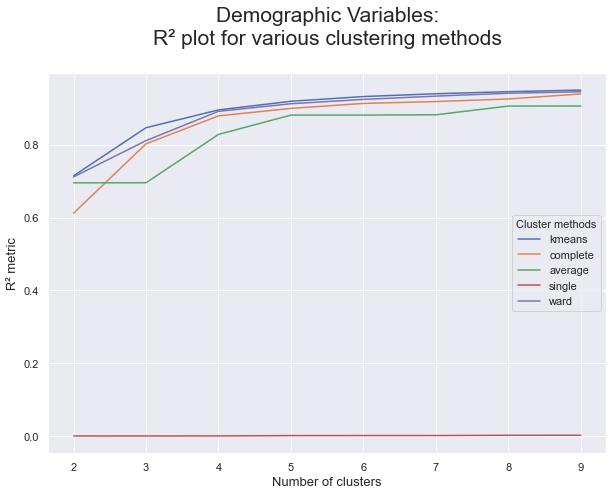

In [754]:
# Visualizing the R² scores for each cluster solution on demographic variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("Demographic Variables:\nR² plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)
plt.show()

### Repeat the process for premium variables

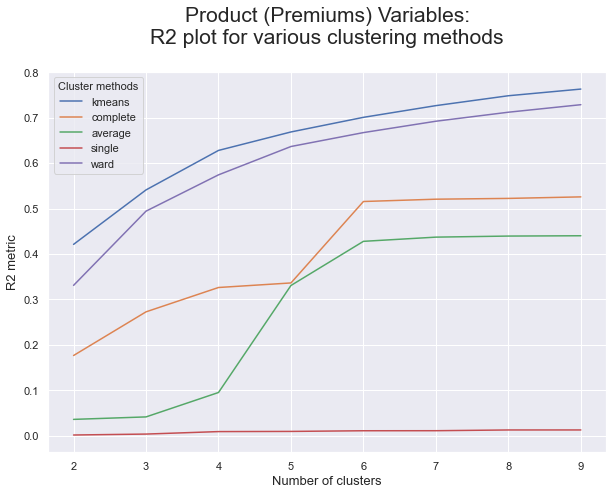

In [755]:
# Obtaining the R² scores for each cluster solution on product variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_prf, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_prf, hierarchical.set_params(linkage=linkage)
    )

# Visualizing the R² scores for each cluster solution on product variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("Product (Premiums) Variables:\nR2 plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)
plt.show()

In [756]:
# Applying the right clustering (algorithm and number of clusters) for each perspective
kmeans_prod = KMeans(
    n_clusters=3,
    init='k-means++',
    n_init=20,
    random_state=42
)
prod_labels = kmeans_prod.fit_predict(df_prf)

kmeans_behav = KMeans(
    n_clusters=4,
    init='k-means++',
    n_init=20,
    random_state=42
)
behavior_labels = kmeans_behav.fit_predict(df_dem)

df['product_labels'] = prod_labels
df['behavior_labels'] = behavior_labels

In [757]:
# Count label frequencies (contigency table)
df.groupby(['product_labels', 'behavior_labels'])\
    .size()\
    .to_frame()\
    .reset_index()\
    .pivot('behavior_labels', 'product_labels', 0)

product_labels,0,1,2
behavior_labels,,,
0,1744,859,123
1,421,1040,1000
2,918,1306,198
3,1778,765,113


In [758]:
### Manual merging: Merge lowest frequency clusters into closest clusters
# Clusters with low frequency to be merged:
to_merge = [(3,2), (1,0), (2,2), (0,2)]

df_centroids = df.groupby(['behavior_labels', 'product_labels'])\
    [metric_features].mean()

# Computing the euclidean distance matrix between the centroids
euclidean = pairwise_distances(df_centroids)
df_dists = pd.DataFrame(
    euclidean, columns=df_centroids.index, index=df_centroids.index
)

# Merging each low frequency clustering (source) to the closest cluster (target)
source_target = {}
for clus in to_merge:
    if clus not in source_target.values():
        source_target[clus] = df_dists.loc[clus].sort_values().index[1]

source_target

{(3, 2): (0, 2), (1, 0): (3, 0), (2, 2): (0, 2)}

In [759]:
df_ = df.copy()

# Changing the behavior_labels and product_labels based on source_target
for source, target in source_target.items():
    mask = (df_['behavior_labels']==source[0]) & (df_['product_labels']==source[1])
    df_.loc[mask, 'behavior_labels'] = target[0]
    df_.loc[mask, 'product_labels'] = target[1]

# New contigency table
df_.groupby(['product_labels', 'behavior_labels'])\
    .size()\
    .to_frame()\
    .reset_index()\
    .pivot('behavior_labels', 'product_labels', 0)

product_labels,0,1,2
behavior_labels,,,
0,1744.0,859.0,434.0
1,NaN,1040.0,1000.0
2,918.0,1306.0,NaN
3,2199.0,765.0,NaN


### Merging using Hierarchical clustering

In [760]:
# Centroids of the concatenated cluster labels
df_centroids = df.groupby(['behavior_labels', 'product_labels'])\
    [metric_features].mean()
df_centroids

FirstPolYear  BirthYear  MonthSal  CustMonVal  \
behavior_labels product_labels                                                  
0               0                  -0.009947  -0.338179  0.322420    0.018417   
                1                  -0.010484  -0.516393  0.406314    0.029951   
                2                  -0.009809  -0.519109  0.365503    0.040410   
1               0                  -0.009747   0.936011 -0.979767    0.006971   
                1                  -0.010574   1.052057 -1.034554    0.030074   
                2                  -0.009789   1.336700 -1.216111    0.057608   
2               0                  -0.009550  -1.129706  1.092655    0.001256   
                1                  -0.009260  -1.144260  1.101256    0.010421   
                2                  -0.008177  -1.110177  1.069343    0.028319   
3               0                  -0.010227   0.338824 -0.345525    0.011034   
                1                  -0.009225   0.531845 -0.418558    0.012489   
                2                  -0.009212   0.540496 -0.386604    0.053273   

                                ClaimsRate  PremMotor  PremHousehold  \
behavior_labels product_labels                                         
0               0                -0.039323   0.672810      -0.395546   
                1                -0.019222  -0.189276       0.164870   
                2                -0.018566  -0.636616       0.455490   
1               0                -0.024298   0.300349      -0.341030   
                1                -0.015745  -0.484852       0.260073   
                2                -0.009696  -1.044911       0.955770   
2               0                -0.019074   0.329686      -0.350625   
                1                -0.005996  -0.414507       0.122319   
                2                -0.007149  -0.832023       0.466992   
3               0                -0.032070   0.570864      -0.419360   
                1                -0.008995  -0.269875       0.071308   
                2                -0.023826  -0.708439       0.515033   

                                PremHealth  PremLife  PremWork  
behavior_labels product_labels                                  
0               0                -0.224402 -0.615805 -0.545462  
                1                 0.019877  0.174762  0.142719  
                2                -0.111115  1.433450  1.174073  
1               0                 0.014468 -0.575910 -0.498202  
                1                 0.206561  0.093039  0.206221  
                2                -0.052385  1.823024  1.494997  
2               0                -0.010344 -0.540013 -0.492612  
                1                 0.205539  0.077223  0.127972  
                2                 0.028183  1.672266  0.944797  
3               0                -0.143117 -0.618164 -0.559975  
                1                 0.118036  0.073563  0.126973  
                2                -0.056165  1.551988  0.921265

In [761]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)
hclust_labels = hclust.fit_predict(df_centroids)

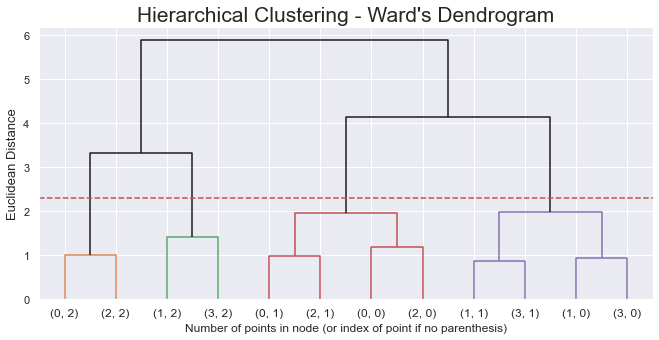

In [762]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 2.3
dendrogram(linkage_matrix, truncate_mode='level', labels=df_centroids.index, p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

In [763]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    n_clusters=7
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids  # centroid's cluster labels

FirstPolYear  BirthYear  MonthSal  CustMonVal  \
behavior_labels product_labels                                                  
0               0                  -0.009947  -0.338179  0.322420    0.018417   
                1                  -0.010484  -0.516393  0.406314    0.029951   
                2                  -0.009809  -0.519109  0.365503    0.040410   
1               0                  -0.009747   0.936011 -0.979767    0.006971   
                1                  -0.010574   1.052057 -1.034554    0.030074   
                2                  -0.009789   1.336700 -1.216111    0.057608   
2               0                  -0.009550  -1.129706  1.092655    0.001256   
                1                  -0.009260  -1.144260  1.101256    0.010421   
                2                  -0.008177  -1.110177  1.069343    0.028319   
3               0                  -0.010227   0.338824 -0.345525    0.011034   
                1                  -0.009225   0.531845 -0.418558    0.012489   
                2                  -0.009212   0.540496 -0.386604    0.053273   

                                ClaimsRate  PremMotor  PremHousehold  \
behavior_labels product_labels                                         
0               0                -0.039323   0.672810      -0.395546   
                1                -0.019222  -0.189276       0.164870   
                2                -0.018566  -0.636616       0.455490   
1               0                -0.024298   0.300349      -0.341030   
                1                -0.015745  -0.484852       0.260073   
                2                -0.009696  -1.044911       0.955770   
2               0                -0.019074   0.329686      -0.350625   
                1                -0.005996  -0.414507       0.122319   
                2                -0.007149  -0.832023       0.466992   
3               0                -0.032070   0.570864      -0.419360   
                1                -0.008995  -0.269875       0.071308   
                2                -0.023826  -0.708439       0.515033   

                                PremHealth  PremLife  PremWork  hclust_labels  
behavior_labels product_labels                                                 
0               0                -0.224402 -0.615805 -0.545462              0  
                1                 0.019877  0.174762  0.142719              2  
                2                -0.111115  1.433450  1.174073              1  
1               0                 0.014468 -0.575910 -0.498202              5  
                1                 0.206561  0.093039  0.206221              4  
                2                -0.052385  1.823024  1.494997              6  
2               0                -0.010344 -0.540013 -0.492612              0  
                1                 0.205539  0.077223  0.127972              2  
                2                 0.028183  1.672266  0.944797              1  
3               0                -0.143117 -0.618164 -0.559975              5  
                1                 0.118036  0.073563  0.126973              4  
                2                -0.056165  1.551988  0.921265              3

In [764]:
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()

df_ = df.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_['merged_labels'] = df_.apply(
    lambda row: cluster_mapper[
        (row['behavior_labels'], row['product_labels'])
    ], axis=1
)

# Merged cluster centroids
df_.groupby('merged_labels').mean()[metric_features]

,FirstPolYear,BirthYear,MonthSal,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
merged_labels,,,,,,,,,,
0,-0.009810,-0.611140,0.588038,0.012499,-0.032340,0.554483,-0.380055,-0.150584,-0.589668,-0.527236
1,-0.008802,-0.883693,0.799647,0.032952,-0.011524,-0.757147,0.462585,-0.025192,1.580757,1.032650
2,-0.009746,-0.895143,0.825526,0.018170,-0.011243,-0.325143,0.139201,0.131875,0.115923,0.133823
3,-0.009212,0.540496,-0.386604,0.053273,-0.023826,-0.708439,0.515033,-0.056165,1.551988,0.921265
4,-0.010002,0.831580,-0.773481,0.022621,-0.012884,-0.393740,0.180070,0.169042,0.084785,0.172634
5,-0.010135,0.453156,-0.466951,0.010256,-0.030582,0.519074,-0.404364,-0.112948,-0.610074,-0.548148
6,-0.009789,1.336700,-1.216111,0.057608,-0.009696,-1.044911,0.955770,-0.052385,1.823024,1.494997


In [765]:
#Merge cluster contigency table
# Getting size of each final cluster
df_counts = df_.groupby('merged_labels')\
    .size()\
    .to_frame()
# Getting the product and behavior labels
df_counts = df_counts\
    .rename({v:k for k, v in cluster_mapper.items()})\
    .reset_index()

df_counts['behavior_labels'] = df_counts['merged_labels'].apply(lambda x: x[0])
df_counts['product_labels'] = df_counts['merged_labels'].apply(lambda x: x[1])
df_counts.pivot('behavior_labels', 'product_labels', 0)

product_labels,0,1,2
behavior_labels,,,
1,NaN,NaN,1000.0
2,2662.0,2165.0,321.0
3,2199.0,1805.0,113.0


In [766]:
df = df_.copy()

## Cluster Analysis

In [767]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

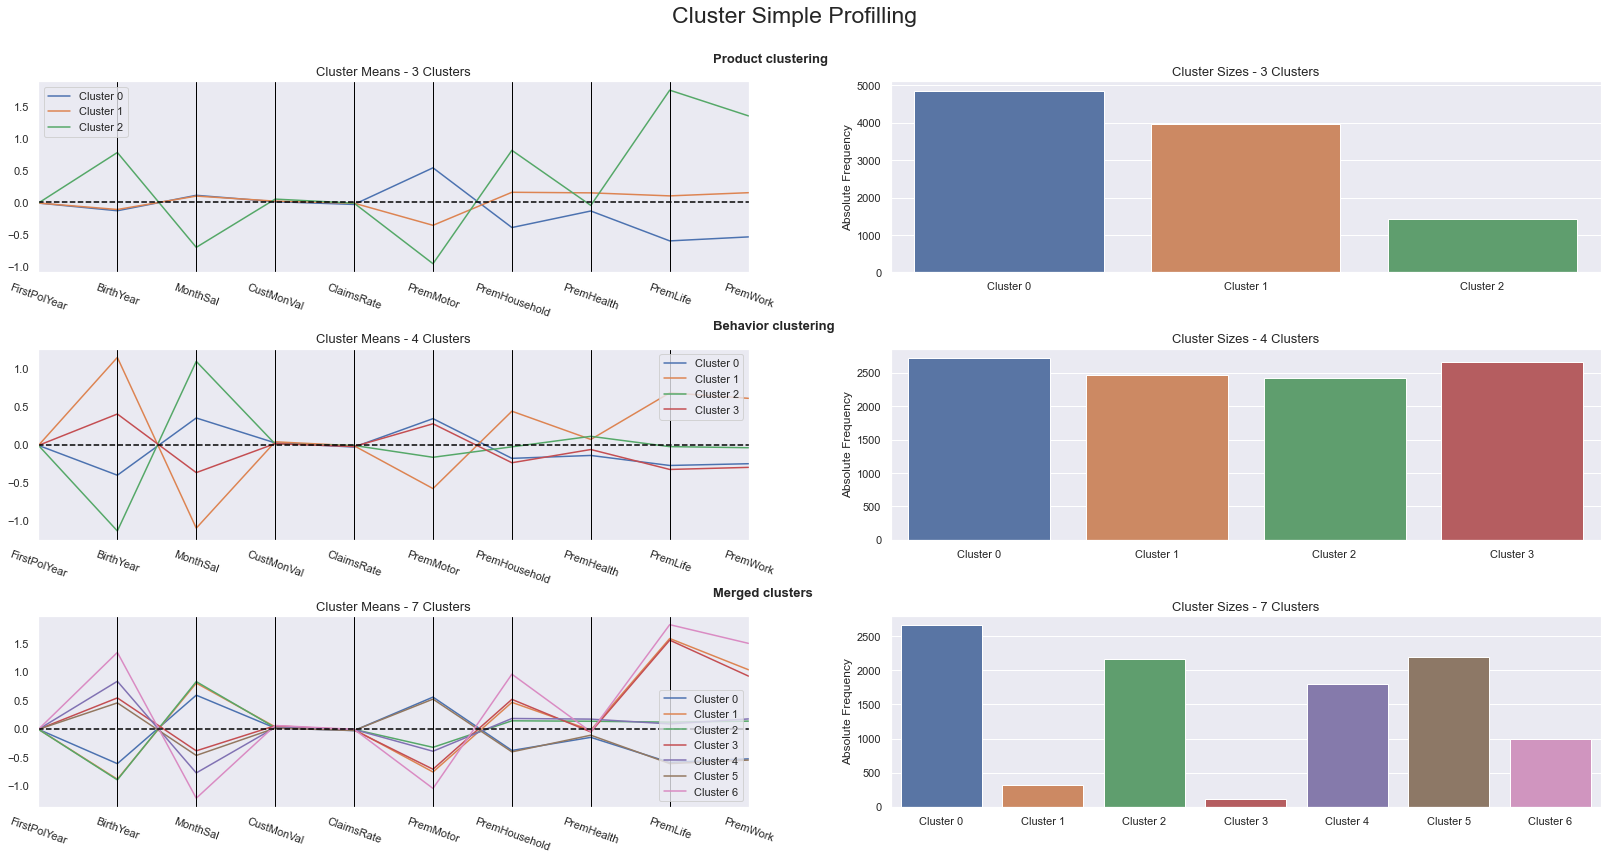

In [768]:
# Profilling each cluster (product, behavior, merged)
cluster_profiles(
    df = df[metric_features + ['product_labels', 'behavior_labels', 'merged_labels']], 
    label_columns = ['product_labels', 'behavior_labels', 'merged_labels'], 
    figsize = (28, 13), 
    compar_titles = ["Product clustering", "Behavior clustering", "Merged clusters"]
)

## Cluster visualization using t-SNE

In [769]:
# This is step can be quite time consuming
two_dim = TSNE(random_state=42).fit_transform(df[metric_features])

c:\Users\Crs\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Crs\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [770]:
df

,FirstPolYear,BirthYear,MonthSal,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,EducDeg_2.0,EducDeg_3.0,EducDeg_4.0,GeoLivArea_2.0,GeoLivArea_3.0,GeoLivArea_4.0,Children_1.0,product_labels,behavior_labels,merged_labels
CustID,,,,,,,,,,,,,,,,,,,,
1,-0.011847,0.710299,-0.284984,0.104371,-0.120944,0.355212,-0.371495,-0.085411,0.113765,-0.472216,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,3,5
2,-0.019683,1.370192,-1.582496,-0.158822,0.129328,-1.054649,0.583611,-0.185718,3.228396,1.264871,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2,1,6
3,-0.000094,0.101166,-0.198484,0.167947,-0.158656,-0.446602,0.039903,-0.159043,0.944643,1.126473,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,3,3
4,-0.002053,0.659538,-1.217463,-0.100160,0.084759,-0.558441,-0.473883,0.471770,-0.132710,-0.249338,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1,1,4
5,-0.009888,0.253449,-0.643098,-0.073321,0.053904,0.179304,-0.461262,0.037074,-0.482465,0.005853,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10292,-0.013806,-0.964816,0.589539,-0.091484,0.074474,0.439740,-0.456582,0.007391,-0.672549,-0.513288,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0,2,0
10293,-0.027518,-0.812533,-0.065272,0.630979,-0.254651,-0.789488,2.340806,-0.095925,-0.606864,1.245406,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,2
10294,0.005783,0.405732,0.355987,0.177933,-0.182655,0.486469,-0.220181,-0.099306,-0.611511,-0.705800,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,3,5


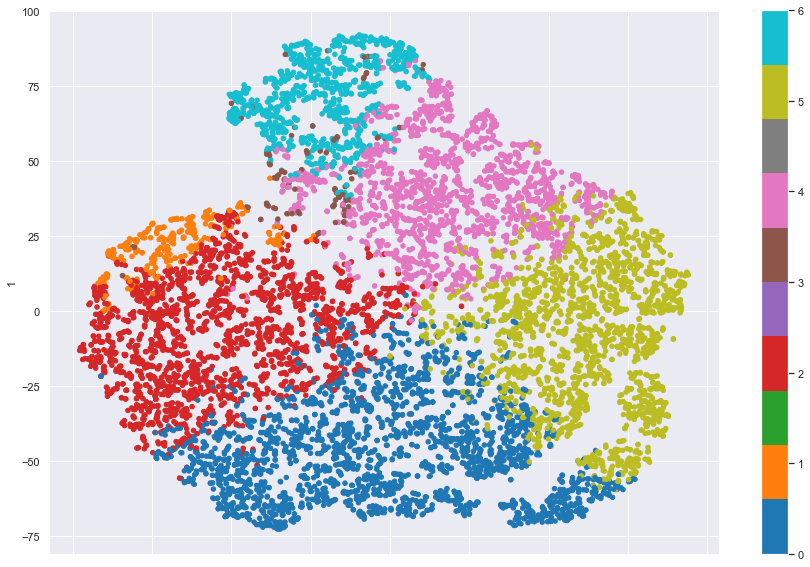

In [771]:
# t-SNE visualization
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df['merged_labels'], colormap='tab10', figsize=(15,10))
plt.show()

## Assess feature importance and reclassify outliers
### Using the R²
What proportion of each variables total SS is explained between clusters?

In [772]:
def get_ss_variables(df):
    """Get the SS for each variable
    """
    ss_vars = df.var() * (df.count() - 1)
    return ss_vars

def r2_variables(df, labels):
    """Get the R² for each variable
    """
    sst_vars = get_ss_variables(df)
    ssw_vars = np.sum(df.groupby(labels).apply(get_ss_variables))
    return 1 - ssw_vars/sst_vars

In [773]:
# We are essentially decomposing the R² into the R² for each variable
r2_variables(df[metric_features + ['merged_labels']], 'merged_labels').drop('merged_labels')

FirstPolYear     0.000379
BirthYear        0.813330
MonthSal         0.761805
CustMonVal       0.010642
ClaimsRate       0.007972
PremMotor        0.745327
PremHousehold    0.405928
PremHealth       0.278651
PremLife         0.602211
PremWork         0.497632
dtype: float64

### Using a Decision Tree
We get the normalized total reduction of the criterion (gini or entropy) brought by that feature (also known as Gini importance).

In [776]:
# Preparing the data
X = df.drop(columns=['product_labels','behavior_labels','merged_labels'])
y = df.merged_labels

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fitting the decision tree
dt = DecisionTreeClassifier(random_state=42, max_depth=3)
dt.fit(X_train, y_train)
print("It is estimated that in average, we are able to predict {0:.2f}% of the customers correctly".format(dt.score(X_test, y_test)*100))

It is estimated that in average, we are able to predict 82.85% of the customers correctly


In [777]:
df

,FirstPolYear,BirthYear,MonthSal,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,EducDeg_2.0,EducDeg_3.0,EducDeg_4.0,GeoLivArea_2.0,GeoLivArea_3.0,GeoLivArea_4.0,Children_1.0,product_labels,behavior_labels,merged_labels
CustID,,,,,,,,,,,,,,,,,,,,
1,-0.011847,0.710299,-0.284984,0.104371,-0.120944,0.355212,-0.371495,-0.085411,0.113765,-0.472216,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,3,5
2,-0.019683,1.370192,-1.582496,-0.158822,0.129328,-1.054649,0.583611,-0.185718,3.228396,1.264871,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2,1,6
3,-0.000094,0.101166,-0.198484,0.167947,-0.158656,-0.446602,0.039903,-0.159043,0.944643,1.126473,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,3,3
4,-0.002053,0.659538,-1.217463,-0.100160,0.084759,-0.558441,-0.473883,0.471770,-0.132710,-0.249338,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1,1,4
5,-0.009888,0.253449,-0.643098,-0.073321,0.053904,0.179304,-0.461262,0.037074,-0.482465,0.005853,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10292,-0.013806,-0.964816,0.589539,-0.091484,0.074474,0.439740,-0.456582,0.007391,-0.672549,-0.513288,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0,2,0
10293,-0.027518,-0.812533,-0.065272,0.630979,-0.254651,-0.789488,2.340806,-0.095925,-0.606864,1.245406,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,2
10294,0.005783,0.405732,0.355987,0.177933,-0.182655,0.486469,-0.220181,-0.099306,-0.611511,-0.705800,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,3,5


In [778]:
# Assessing feature importance
pd.Series(dt.feature_importances_, index=X_train.columns)

FirstPolYear      0.000000
BirthYear         0.312791
MonthSal          0.071078
CustMonVal        0.000000
ClaimsRate        0.000000
PremMotor         0.581338
PremHousehold     0.000000
PremHealth        0.000000
PremLife          0.034794
PremWork          0.000000
EducDeg_2.0       0.000000
EducDeg_3.0       0.000000
EducDeg_4.0       0.000000
GeoLivArea_2.0    0.000000
GeoLivArea_3.0    0.000000
GeoLivArea_4.0    0.000000
Children_1.0      0.000000
dtype: float64

In [779]:
# Predicting the cluster labels of the outliers
df_out['merged_labels'] = dt.predict(df_out)
df_out.head()

,FirstPolYear,BirthYear,MonthSal,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,EducDeg_2.0,EducDeg_3.0,EducDeg_4.0,GeoLivArea_2.0,GeoLivArea_3.0,GeoLivArea_4.0,Children_1.0,merged_labels
CustID,,,,,,,,,,,,,,,,,,
52,-0.017724,-0.101878,0.629329,-7.653720,8.439743,1.213204,-0.540109,-0.480282,-0.773504,-0.976174,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0
113,0.011659,0.558016,-0.131878,-4.572573,5.110777,1.028367,-0.584213,-0.391233,-0.796948,-0.589008,0.0,0.0,1.0,0.0,0.0,0.0,1.0,5
136,0.011659,1.014865,-0.285849,-5.333151,4.819364,-0.014464,-0.135094,-0.095553,2.003199,-0.859382,0.0,1.0,0.0,0.0,0.0,1.0,1.0,4
150,-0.004012,1.319431,-1.316939,0.039994,-0.038663,-1.113993,-0.037385,-0.480282,-0.487111,7.988203,0.0,0.0,0.0,0.0,0.0,1.0,1.0,6
172,-0.002053,1.065626,-1.228708,-85.242773,87.580672,0.365701,-0.373055,-0.016274,-0.733587,-0.441850,0.0,1.0,0.0,0.0,0.0,1.0,1.0,5


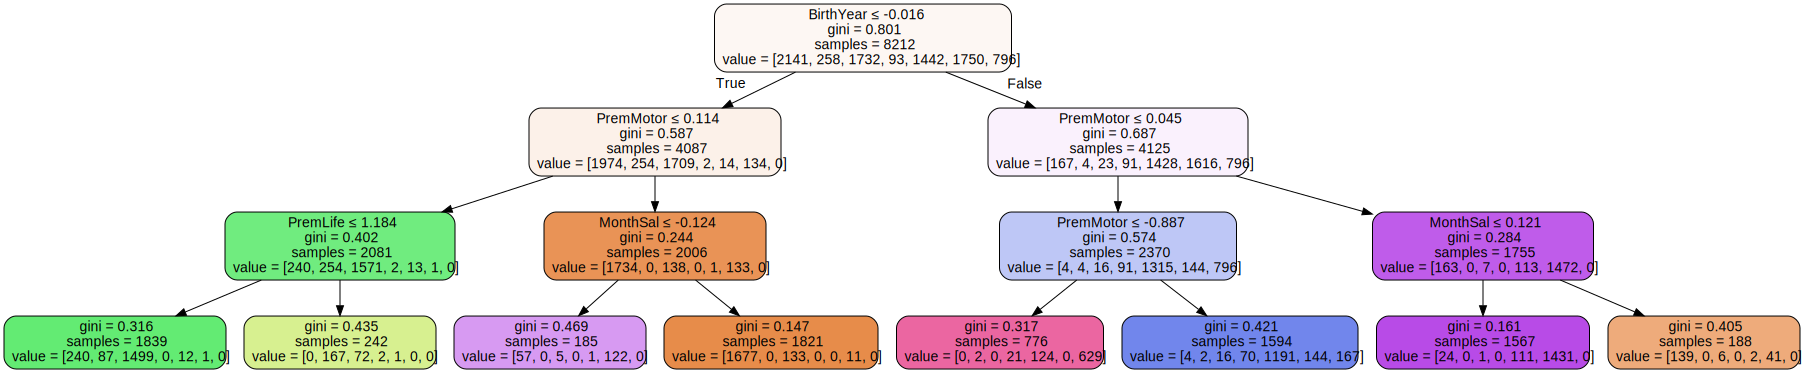

In [780]:
# Visualizing the decision tree
dot_data = export_graphviz(dt, out_file=None, 
                           feature_names=X.columns.to_list(),
                           filled=True,
                           rounded=True,
                           special_characters=True)  
graphviz.Source(dot_data)

In [782]:
df.columns

Index(['FirstPolYear', 'BirthYear', 'MonthSal', 'CustMonVal', 'ClaimsRate',
       'PremMotor', 'PremHousehold', 'PremHealth', 'PremLife', 'PremWork',
       'EducDeg_2.0', 'EducDeg_3.0', 'EducDeg_4.0', 'GeoLivArea_2.0',
       'GeoLivArea_3.0', 'GeoLivArea_4.0', 'Children_1.0', 'product_labels',
       'behavior_labels', 'merged_labels'],
      dtype='object')

In [657]:
non_metric_features

['EducDeg', 'GeoLivArea', 'Children']

In [834]:
## Who is buying PremLife Insurance?
##Potential PermLife buyers
ts = df[(df['PremLife'] <= 1.184) & (df['PremMotor'] <= 0.114) & (df['BirthYear'] <= -0.016)]

2    1878
0     302
1     111
4      15
5       2
Name: merged_labels, dtype: int64

In [842]:
demo = data[['CustID']+non_metric_features].set_index('CustID')
x = pd.merge(demo, ts, left_index=True, right_index=True)

In [844]:
x['merged_labels'].value_counts()

2    1878
0     302
1     111
4      15
5       2
Name: merged_labels, dtype: int64

In [845]:
##Potential PermLife buyers
pt = x[x['merged_labels'] == 2]

In [848]:
for var in non_metric_features:    
    print(pt[var].value_counts())

b'2 - High School'    849
b'3 - BSc/MSc'        784
b'1 - Basic'          187
b'4 - PhD'             54
Name: EducDeg, dtype: int64
4.0    791
1.0    532
3.0    352
2.0    203
Name: GeoLivArea, dtype: int64
0.0    1242
1.0     632
Name: Children, dtype: int64


In [849]:
pd.crosstab(pt['Children'], pt['GeoLivArea'])

GeoLivArea,1.0,2.0,3.0,4.0
Children,,,,
0.0,359,130,228,525
1.0,173,69,124,266
